# News Mood

## Observable Trends

- Most tweets are concentrated at a polarity of 0, meaning that media sources aim to report in a neutral fashion.
- Per the data on 06/07/2018, all media sources were overall tweeting negatively.
- Per the data on 06/07/2018, CNN was tweeting most neutral while CBSNews was tweeting most negatively.

In [5]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [7]:
# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [8]:
# Target Account
target_users = ("BBCWorld","CBSNews", "CNN", "FoxNews", "nytimes")

sentiments = []

for target in target_users:
    
    # Counter
    counter = 1
    
    # Variable for max_id
    oldest_tweet = None

    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):

            # Get all tweets from home feed
            public_tweets = api.user_timeline(target,  max_id = oldest_tweet)

            # Loop through all tweets
            for tweet in public_tweets:

                # Run Vader Analysis on each tweet
                results = analyzer.polarity_scores(tweet["text"])
                compound = results["compound"]
                pos = results["pos"]
                neu = results["neu"]
                neg = results["neg"]
                tweets_ago = counter
                
                # Get Tweet ID, subtract 1, and assign to oldest_tweet
                oldest_tweet = tweet['id'] - 1

                # Add sentiments for each tweet into a list
                sentiments.append({"Source Account": target,
                           "Text": tweet["text"],
                           "Date": tweet["created_at"],
                           "Positive": pos,
                           "Neutral": neu,
                           "Negative": neg,
                           "Compound": compound,
                            "Tweets Ago": counter})
                
                # Add to counter 
                counter += 1

In [9]:
# Convert sentiments to DataFrame
sentiments_pd = pd.DataFrame(sentiments)
sentiments_pd.head()

,Compound,Date,Negative,Neutral,Positive,Source Account,Text,Tweets Ago
0,-0.7650,Thu Jun 07 15:32:15 +0000 2018,0.524,0.476,0.000,BBCWorld,Kate Spade death: Mental illness 'doesn't disc...,1
1,0.4404,Thu Jun 07 15:17:30 +0000 2018,0.131,0.611,0.258,BBCWorld,Silent alert system for women who are being at...,2
2,0.0000,Thu Jun 07 15:11:02 +0000 2018,0.000,1.000,0.000,BBCWorld,Korean woman survives six days in Australian w...,3
3,-0.7783,Thu Jun 07 15:11:00 +0000 2018,0.531,0.469,0.000,BBCWorld,Israel blames Iran for Gaza border violence ht...,4
4,-0.7003,Thu Jun 07 14:45:00 +0000 2018,0.492,0.508,0.000,BBCWorld,Ship hack 'risks chaos in English Channel' htt...,5


In [10]:
# Reorganize columns
sentiments_pd_reorg = sentiments_pd[["Source Account", "Text", "Date", "Compound", "Positive", "Neutral",
                                    "Negative", "Tweets Ago"]]
sentiments_pd_reorg.head()

# Export to csv
sentiments_pd_reorg.to_csv("output/Twitter_sentiments_news.csv",
                     encoding="utf-8")

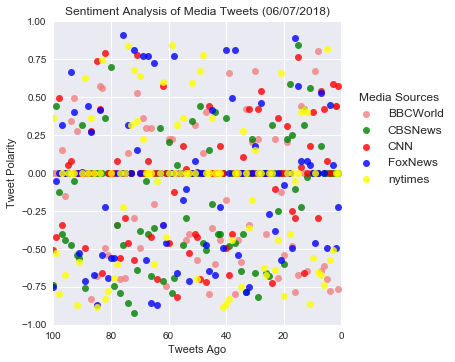

In [11]:
# Create plot

sns.set(style="darkgrid")
scatter_plot = sns.lmplot(x = "Tweets Ago", y = "Compound", data = sentiments_pd_reorg,
                         hue= "Source Account", palette=dict(BBCWorld="lightcoral", 
                            CBSNews="green", CNN="red", FoxNews='blue', nytimes='yellow'), 
                         fit_reg=False, legend=False)
scatter_plot = (scatter_plot.set(xlim=(100, 0), ylim=(-1.0, 1.0)))

# Incorporate the other graph properties
now = datetime.now()
now = now.strftime("%m/%d/%Y")
plt.title(f"Sentiment Analysis of Media Tweets ({now})")
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.grid(True)

# Create a legend
lgnd = plt.legend(fontsize="medium", loc='upper center', bbox_to_anchor=(1.2, 0.8), title="Media Sources")

# Save figure
plt.savefig("output/SentimentAnalysisScatter.png")

# Show plot
plt.show()

In [12]:
account_compound_mean = sentiments_pd_reorg.groupby(["Source Account"]).mean()["Compound"]
account_compound_mean

Source Account
BBCWorld   -0.100531
CBSNews    -0.149098
CNN        -0.021505
FoxNews    -0.048664
nytimes    -0.089586
Name: Compound, dtype: float64

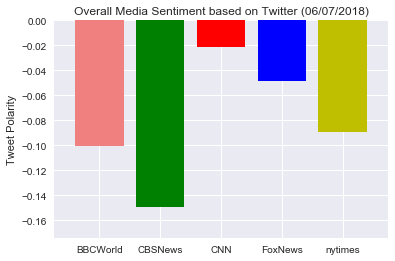

In [14]:
# Create plot

plt.bar(target_users, account_compound_mean, color = ['lightcoral','g','r','b','y'], alpha=1, align="center")

# Tell matplotlib where to place each of the x-axis labels
tick_locations = [value for value in target_users]
plt.xticks(tick_locations, target_users)

# Set the x-limits
plt.xlim(-0.75, len(target_users)-0.25)

# Set the y-limits
plt.ylim(min(account_compound_mean)-.025), (max(account_compound_mean)+.05)

# Give our chart some labels and a title
plt.title(f"Overall Media Sentiment based on Twitter ({now})")
plt.ylabel("Tweet Polarity")

# Save figure
plt.savefig("output/SentimentAnalysisOverall.png")

# Print our chart to the screen
plt.show()